
## 《合成孔径雷达成像——算法与实现》中3.5.1基带信号中的失配影响



In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.fft import fft,fftshift,ifft,ifftshift

plt.rcParams['font.sans-serif'] = ['SimHei'] # 指定默认字体 
plt.rcParams['axes.unicode_minus'] = False # 解决保存图像是负号'-'显示为方块的问题 

In [38]:
#% 参数设置
TBP = 42;                #% 时间带宽乘积
T = 7.2e-6;              #% 脉冲持续时间
N_st = 2**11;                         
#% 参数计算
B = TBP/T;               #% 信号带宽
K = B/T;                 #% 调频频率
ratio = 200;             #% 过采样率，使用过高的过采样率是为了方便地实现升采样
F = ratio*B;             #% 采样频率
N = int(2*np.ceil(F*T/2));      # % 采样点数
dt = T/N;                #% 采样时间间隔
df = F/N;                #% 采样频率间隔
#% 参数设置
t_c = 0e-6;              #% 时间偏移
#% 参数计算
f_c = -K*t_c;            #% 中心频点
#% 变量设置
t1 = np.arange(-T/2,T/2,dt);     #% 时间变量
f1 = np.arange(-F/2,F/2,df);     #% 频率变量
#% 信号表达                             
st = np.exp(1j*np.pi*K*(t1-t_c)**2);          #% 发射信号
#% % 绘图
#% H1 = figure;
#% set(H1,'position',[100,100,600,300]);
# % subplot(211),plot(t1,real(st),'k')
# % subplot(212),plot(t1,imag(st),'k')
# % suptitle('发射信号')
# % 参数设置
t_0 = 10e-6;              #% 回波时延
# % 变量设置
t2 = np.arange(-T/2+t_0,T/2+t_0,dt);           # % 时间变量
f2 = np.arange(-F/2+f_c,F/2+f_c,df);           # % 频率变量
#% 信号表达                                                                 
srt = np.exp(1j*np.pi*K*(t2-t_c-t_0)**2);    # % 回波信号
Srf = fftshift(fft(srt));

In [39]:
#% 参数设置
QPE = np.linspace(0,0.8*np.pi,N);            #% 二次相位误差
dk = QPE/(np.pi*(T/2)**2);                # % 调频率误差
#% 参数设置
IRW1  = np.zeros(N);                    #% 初始化冲激响应宽度
PSLR1 = np.zeros(N);                    #% 初始化峰值旁瓣比
ISLR1 = np.zeros(N);                    #% 初始化积分旁瓣比
IRW2  = np.zeros(N);                    #% 初始化冲激响应宽度
PSLR2 = np.zeros(N);                    #% 初始化峰值旁瓣比
ISLR2 = np.zeros(N);                    #% 初始化积分旁瓣比
IRW3  = np.zeros(N);                    #% 初始化冲激响应宽度
PSLR3 = np.zeros(N);                    #% 初始化峰值旁瓣比
ISLR3 = np.zeros(N);                    #% 初始化积分旁瓣比


In [42]:
# 
from numpy import sum,isrealobj,sqrt
from numpy.random import standard_normal
from scipy.signal import find_peaks
def awgn(s,SNRdB,L=1):
    """
    AWGN channel
    Add AWGN noise to input signal. The function adds AWGN noise vector to signal 's' to 
    generate a resulting signal vector 'r' of specified SNR in dB. It also
    returns the noise vector 'n' that is added to the signal 's' and the power spectral density N0 of noise added
    Parameters:
        s : input/transmitted signal vector
        SNRdB : desired signal to noise ratio (expressed in dB) for the received signal
        L : oversampling factor (applicable for waveform simulation) default L = 1.
    Returns:
        r : received signal vector (r=s+n)
"""
    gamma = 10**(SNRdB/10) #SNR to linear scale
    if s.ndim==1:# if s is single dimensional vector
        P=L*sum(abs(s)**2)/len(s) #Actual power in the vector
    else: # multi-dimensional signals like MFSK
        P=L*sum(sum(abs(s)**2))/len(s) # if s is a matrix [MxN]
    N0=P/gamma # Find the noise spectral density
    if isrealobj(s):# check if input is real/complex object type
        n = sqrt(N0/2)*standard_normal(s.shape) # computed noise
    else:
        n = sqrt(N0/2)*(standard_normal(s.shape)+1j*standard_normal(s.shape))
    r = s + n # received signal
    return r

def pslr(Af):
    af = Af    
    #% 提取PSLR
    pks= find_peaks( af );
#     print( pks[0])
    sort_array = np.sort(af[pks[0]])[::-1]
#     print(sort_array)
#     PSLR = 20*np.log10( sort_array[0] )
    # 次峰
    PSLR = sort_array[1]  
    return PSLR
def irw(Af):
    #% 找到Af的最大位置
    locmax = np.argmax( Af );
    #% 找到locmax左边最接近-3dB的位置
    locleft = np.argmin(np.abs(Af[0:locmax]/np.max(np.abs(Af[0:locmax]))-0.707));
    #% 找到locmax右边最接近-3dB的位置
    locright = np.min(np.abs(Af[locmax+1:]/np.max(np.abs(Af[locmax+1:]))-0.707));
    locright = locright + locmax;
    #% 得到3dB波束宽度
    irw = locright-locleft
    return irw,locleft,locright

def  islr(af,Nr):      
#     #% 计算ISLR
#     #% af取平方
#     af2 = af**2;
#     #% 计算ptotal
#     ptotal = np.trapz( t_out, x=af2 );
#     #% 计算pmain
#     loc_temp       = int(np.round( IRW*alpha/2/dtnow ));
#     loc_main_left  = locmax - loc_temp;
#     loc_main_right = locmax + loc_temp;
#     pmain          = np.trapz( t_out[loc_main_left:loc_main_right+1], x=af2[loc_main_left:loc_main_right+1] );
#     #% 计算ISLR
#     ISLR = 10*np.log10( np.abs((ptotal-pmain)/pmain) );
#     return ISLR
    #% 找到Af的最大位置
    locmax = np.argmax( af );
    #% 找到locmax左边最接近-3dB的位置
    locleft = np.argmin(np.abs(af[0:locmax]/np.max(np.abs(af[0:locmax]))-0.707));
    #% 找到locmax右边最接近-3dB的位置
    locright = np.argmin(np.abs(af[locmax+1:]/np.max(np.abs(af[locmax+1:]))-0.707));
    locright = locright + locmax;
    #% 计算总功率
    P_total = np.sum(af[locleft-Nr:locright+Nr+1]**2);
    #% 计算主瓣功率
    P_main = np.sum(af[locleft:locright+1]**2);
    #% 一维积分旁瓣比
    ISLR = 10*np.log10((P_total-P_main)/P_main);
    return ISLR


In [49]:
for i in range(N):
    #% 变量设置
    B_dk = (K+dk[i])*T;
    F_dk = ratio*B_dk;
    df_dk = F_dk/N;
    f3 = np.arange(-F_dk/2+f_c,F_dk/2+f_c,df_dk);          # % 频率变量
    #% 信号表达                                                                 
    st_dk = np.exp(1j*np.pi*(K+dk[i])*t1**2);                  
    Sf_dk = fftshift(fft(st_dk));
    #% 信号变换-->频域方式一
    window_1 = np.kaiser(N,2.8);                        # % 时域窗
    Window_1 = fftshift(window_1);                     #% 频域窗
    ht_dk_1 = np.conj(st_dk[::-1]);                  #   % 将时间反褶后的复制脉冲取复共轭
    ht_window_dk_1 = window_1*ht_dk_1;                #% 加窗
    Hf_dk_1 = fftshift(fft(ht_window_dk_1,N));         #% 计算补零离散傅里叶变换
    #% 信号变换-->频域方式二
    window_2 = np.kaiser(N,2.8);                         #% 时域窗
    Window_2 = fftshift(window_2);                     #% 频域窗
    ht_dk_2 = st_dk;                                   #% 复制信号
    ht_window_dk_2 = window_2*ht_dk_2;                #% 加窗
    Hf_dk_2 = fftshift(np.conj(fft(ht_window_dk_2,N)));   #% 计算补零离散傅里叶变换
    #% 信号变换-->频域方式三
    window_3 = np.kaiser(N,2.8);                        # % 时域窗
    Window_3 = fftshift(window_3);                     #% 频域窗
    Hf_dk_3 = Window_3*np.exp(1j*np.pi*f3**2/(K+dk[i]));    #% 计算补零离散傅里叶变换
#% 参数计算-->方式一                                         
    Soutf_dk_1 = Srf*Hf_dk_1;
    soutt_dk_1 = ifft(ifftshift(Soutf_dk_1));          #% 方式一匹配滤波结果 
    soutt_dk_1_nor = np.abs(soutt_dk_1)/np.max(np.abs(soutt_dk_1));               #% 归一化
    soutt_dk_1_log = 20*np.log10(np.abs(soutt_dk_1)/np.max(np.abs(soutt_dk_1))+np.finfo(np.float64).eps); #% 对数化
    #% 参数计算-->IRW
    irw_dk_1,locleft,locright= irw(fftshift(soutt_dk_1_nor));
    IRW1[i] = irw_dk_1;
    #% 参数计算-->PSLR
    pslr_dk_1 = pslr(fftshift(soutt_dk_1_log));
#     print(pslr_dk_1)
    PSLR1[i] = pslr_dk_1;
    #% 参数计算-->ISLR
    islr_dk_1 = islr(fftshift(soutt_dk_1_nor),5);
    ISLR1[i] = islr_dk_1;
    
#% 参数计算-->方式二                                        
    Soutf_dk_2 = Srf*Hf_dk_2;
    soutt_dk_2 = ifft(ifftshift(Soutf_dk_2));          #% 方式二匹配滤波结果 
    soutt_dk_2_nor = np.abs(soutt_dk_2)/np.max(np.abs(soutt_dk_2));             #  % 归一化
    soutt_dk_2_log = 20*np.log10(np.abs(soutt_dk_2)/np.max(np.abs(soutt_dk_2))+np.finfo(np.float64).eps); #% 对数化
    #% 参数计算-->IRW
    irw_dk_2,locleft,locright = irw(fftshift(soutt_dk_2_nor));
    IRW2[i] = irw_dk_2
    #% 参数计算-->PSLR
    pslr_dk_2 = pslr(fftshift(soutt_dk_2_log));
#     print(pslr_dk_2)
    PSLR2[i] = pslr_dk_2;
    #% 参数计算-->ISLR
    islr_dk_2 = islr(fftshift(soutt_dk_2_nor),5);
    ISLR2[i] = islr_dk_2;
#% 参数计算-->方式三                                         
    Soutf_dk_3 = Srf*Hf_dk_3;
    soutt_dk_3 = ifft(ifftshift(Soutf_dk_3));          #% 方式三匹配滤波结果 
    soutt_dk_3_nor = np.abs(soutt_dk_3)/np.max(np.abs(soutt_dk_3));               #% 归一化
    soutt_dk_3_log = 20*np.log10(np.abs(soutt_dk_3)/np.max(np.abs(soutt_dk_3))+np.finfo(np.float64).eps); #% 对数化
    #% 参数计算-->IRW
    irw_dk_3,locleft,locright = irw(soutt_dk_3_nor);
    IRW3[i] = irw_dk_3;
    #% 参数计算-->PSLR
    pslr_dk_3 = pslr(soutt_dk_3_log);
#     print(pslr_dk_3)
    PSLR3[i] = pslr_dk_3;
    #% 参数计算-->ISLR
    islr_dk_3 = islr(soutt_dk_3_nor,5);
    ISLR3[i] = islr_dk_3;



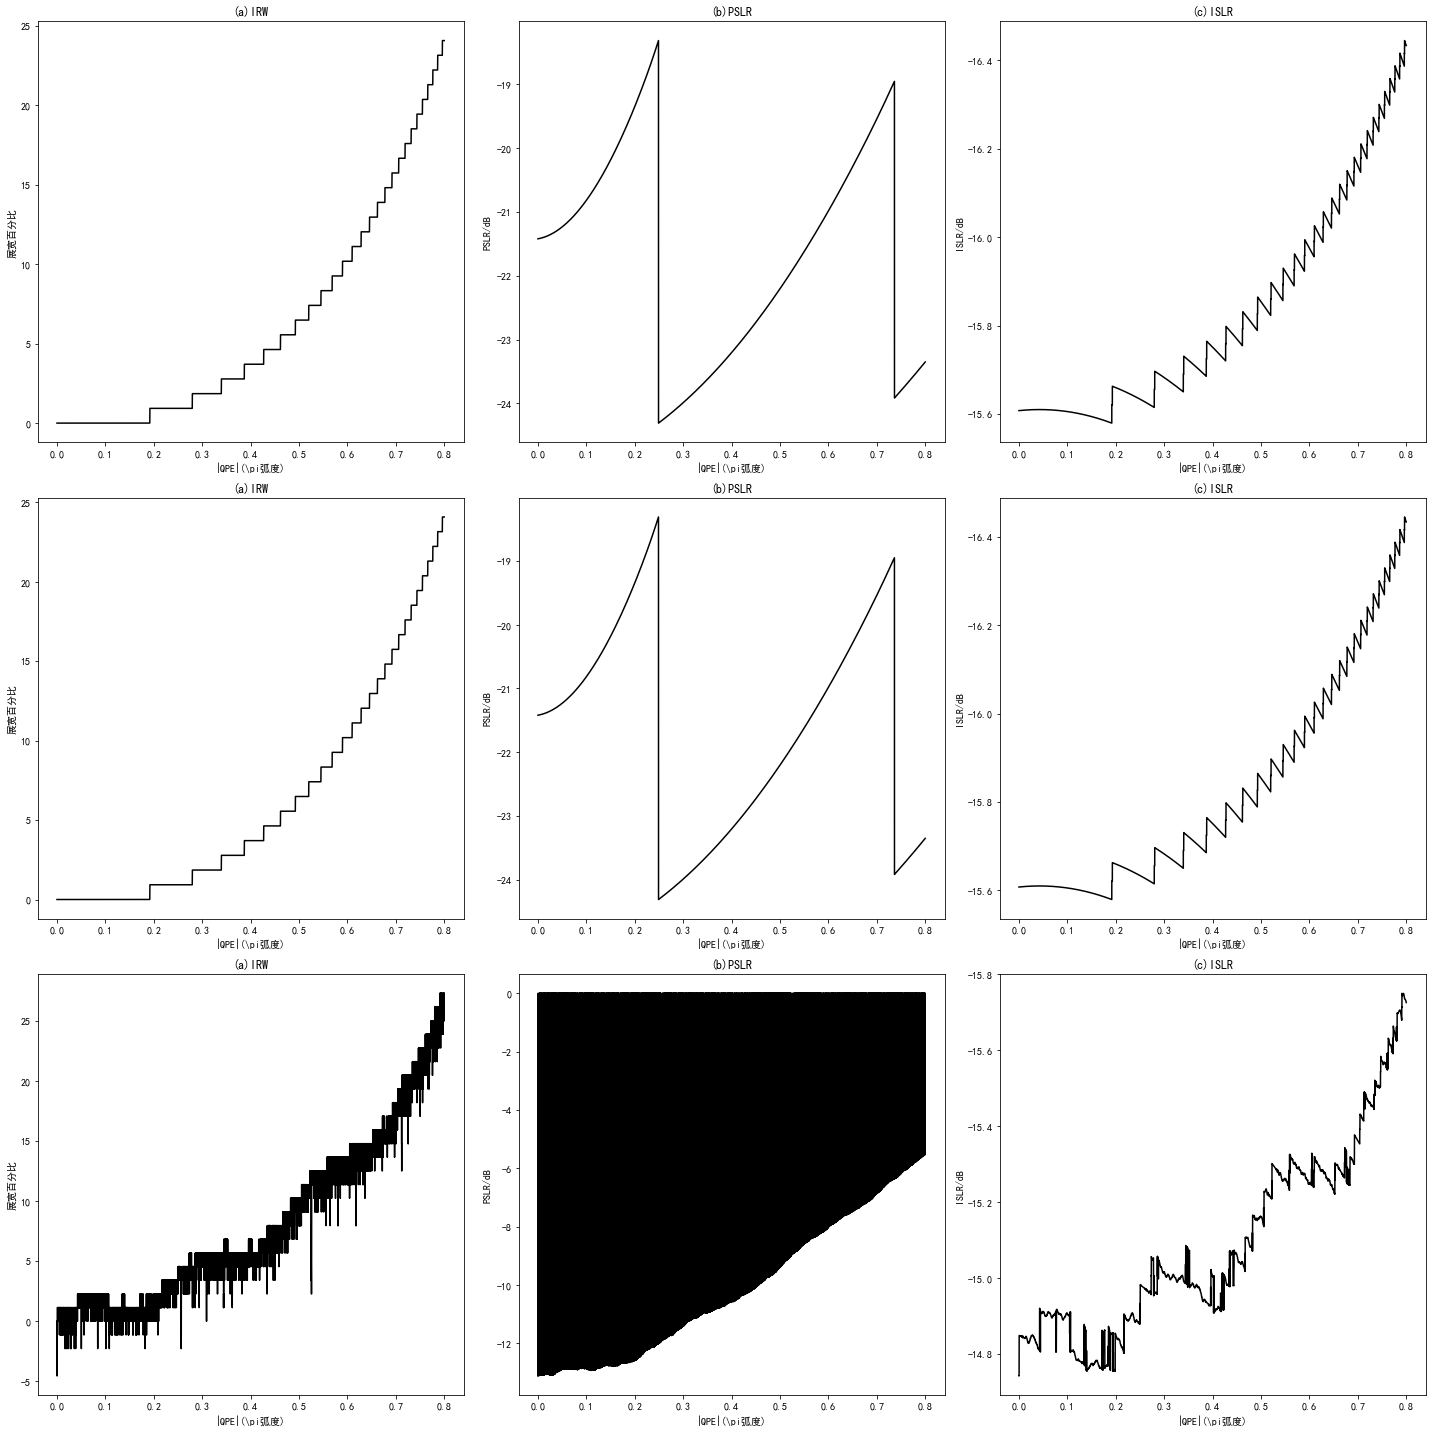

In [51]:
plt.figure(figsize=(20,20))
plt.subplot(331)
plt.plot(QPE/np.pi,(IRW1-IRW1[0])/IRW1[0]*100,'k')
plt.title('(a)IRW');plt.xlabel('|QPE|(\pi弧度)');plt.ylabel('展宽百分比')
plt.subplot(332)
plt.plot(QPE/np.pi,PSLR1,'k')
plt.title('(b)PSLR');plt.xlabel('|QPE|(\pi弧度)');plt.ylabel('PSLR/dB')
plt.subplot(333)
plt.gca().invert_yaxis()
plt.plot(QPE/np.pi,ISLR1,'k')
plt.title('(c)ISLR');plt.xlabel('|QPE|(\pi弧度)');plt.ylabel('ISLR/dB')
plt.subplot(334)
plt.plot(QPE/np.pi,(IRW2-IRW2[0])/IRW2[0]*100,'k')
plt.title('(a)IRW');plt.xlabel('|QPE|(\pi弧度)');plt.ylabel('展宽百分比')
plt.subplot(335);
plt.plot(QPE/np.pi,PSLR2,'k')
plt.title('(b)PSLR');plt.xlabel('|QPE|(\pi弧度)');plt.ylabel('PSLR/dB')
plt.subplot(336)
plt.gca().invert_yaxis()
plt.plot(QPE/np.pi,ISLR2,'k')
plt.title('(c)ISLR');plt.xlabel('|QPE|(\pi弧度)');plt.ylabel('ISLR/dB')
plt.subplot(337)
plt.plot(QPE/np.pi,(IRW3-IRW3[0])/IRW3[0]*100,'k')
plt.title('(a)IRW');plt.xlabel('|QPE|(\pi弧度)');plt.ylabel('展宽百分比')
plt.subplot(338);
plt.plot(QPE/np.pi,PSLR3,'k')
plt.title('(b)PSLR');plt.xlabel('|QPE|(\pi弧度)');plt.ylabel('PSLR/dB')
plt.subplot(339);
plt.gca().invert_yaxis()
plt.plot(QPE/np.pi,ISLR3,'k')
plt.title('(c)ISLR');plt.xlabel('|QPE|(\pi弧度)');plt.ylabel('ISLR/dB')
#suptitle('图3.14 当\beta=2.5时的IRW、PSLR、ISLR与QPE之间的关系')
plt.tight_layout()